In [1]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
MODEL_PATH = "../resources/models/shape_predictor_68_face_landmarks.dat"

## Apply Facial Makeup

In [155]:
class FaceMakeup:
    def __init__(self, landmark_model_path):
        self.face_detector = dlib.get_frontal_face_detector()
        try:
            self.landmark_detector = dlib.shape_predictor(landmark_model_path)
        except:
            print(f"ERROR: unable to load landmark model in this path: {landmark_model_path}")
    
    def applyColor(self, image, eyes_color=None, lips_color=None):
        all_landmarks, _ = self._get_facial_landmarks(image, return_numpy_landmark=True)
        output_image = image.copy()
        if lips_color:
            output_image = self.applyLipsColor(output_image, lips_color, all_landmarks)
        if eyes_color:
            output_image = self.applyEyesColor(output_image, eyes_color, all_landmarks)
        return output_image
    
    def applyLipsColor(self, image, color, all_landmarks=None):
        if all_landmarks is None:
            all_landmarks, _ = self._get_facial_landmarks(image, return_numpy_landmark=True)
        lips_mask = self._extract_lips_region(image, all_landmarks)
        color_lips = np.zeros_like(image)
        color_lips[:] = color[0], color[1], color[2]
        color_lips = cv2.bitwise_and(lips_mask, color_lips)
        color_lips = cv2.GaussianBlur(color_lips, (5,5), 10)
        output_img = cv2.addWeighted(image, 1, color_lips, 0.4,0)
        return output_img
    
    def applyEyesColor(self, image, color, all_landmarks=None):
        if all_landmarks is None:
            all_landmarks, _ = self._get_facial_landmarks(image, return_numpy_landmark=True)
        pupils_mask = self._extract_pupils_region(image, all_landmarks)
        color_pupils = np.zeros_like(image)
        color_pupils[:] = color[0], color[1], color[2]
        color_pupils = cv2.bitwise_and(pupils_mask, color_pupils)
        color_pupils = cv2.GaussianBlur(color_pupils, (5,5), 10)
        output_img = cv2.addWeighted(image, 1, color_pupils, 0.4,0)
        return output_img
    
    def _extract_pupils_region(self, image, all_landmarks):
        # Create mask for eyes region
        eyes_mask = np.zeros_like(image)
        for landmarks in all_landmarks:
            eyes_mask = cv2.fillPoly(eyes_mask, [landmarks[36:42]], (255,255,255)) # left eye
            eyes_mask = cv2.fillPoly(eyes_mask, [landmarks[42:48]], (255,255,255)) # right eye
        # Crop eyes region of original image
        cropped_image = cv2.bitwise_and(image, eyes_mask)
        # Apply binary threshold to extract pupils region
        ret, eyes_bright_mask = cv2.threshold(cropped_image,80,255,cv2.THRESH_BINARY)
        eyes_bright_mask_binary = np.bitwise_or.reduce(eyes_bright_mask, axis=-1) # 1 channel mask
        eyes_bright_mask = cv2.cvtColor(eyes_bright_mask_binary, cv2.COLOR_GRAY2RGB) # 3 channel mask
        pupils_mask = cv2.bitwise_xor(eyes_mask, eyes_bright_mask)
        # Apply Closing & Opening to remove noises in pupil mask
        kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5,5))
        pupils_mask = cv2.morphologyEx(pupils_mask, cv2.MORPH_CLOSE, kernel)
        pupils_mask = cv2.morphologyEx(pupils_mask, cv2.MORPH_OPEN, kernel)       
        return pupils_mask
    
    def _extract_lips_region(self, image, all_landmarks):
        mask = np.zeros_like(image)
        for landmarks in all_landmarks:
            mask = cv2.fillPoly(mask, [landmarks[48:61]], (255,255,255))
        return mask
        
    def _get_facial_landmarks(self, image, return_numpy_landmark=False):
        face_rects = self.face_detector(image, 0)
        all_facial_landmarks = []
        face_bboxes = []
        for face in face_rects:
            face_bbox = (int(face.left()), 
                         int(face.top()), 
                         int(face.right()),
                         int(face.bottom()))
            rect = dlib.rectangle(face_bbox[0], face_bbox[1], face_bbox[2], face_bbox[3])
            landmarks = self.landmark_detector(image, rect)
            if return_numpy_landmark:
                temp_list = []
                for i in range(68):
                    x, y = landmarks.part(i).x, landmarks.part(i).y
                    temp_list.append([x,y])
                all_facial_landmarks.append(np.array(temp_list))
            else:
                all_facial_landmarks.append(landmarks)
            face_bboxes.append(face_bbox)
        return all_facial_landmarks, face_bboxes

In [156]:
IMAGE_PATH = "../resources/images/girl-no-makeup.jpg"
im = cv2.imread(IMAGE_PATH)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [163]:
LIPS_COLOR = (150, 0, 50)
EYES_COLOR = (50, 50, 150)

face_makeup = FaceMakeup(MODEL_PATH)
im_out = face_makeup.applyColor(im_rgb, eyes_color=EYES_COLOR, lips_color=LIPS_COLOR)

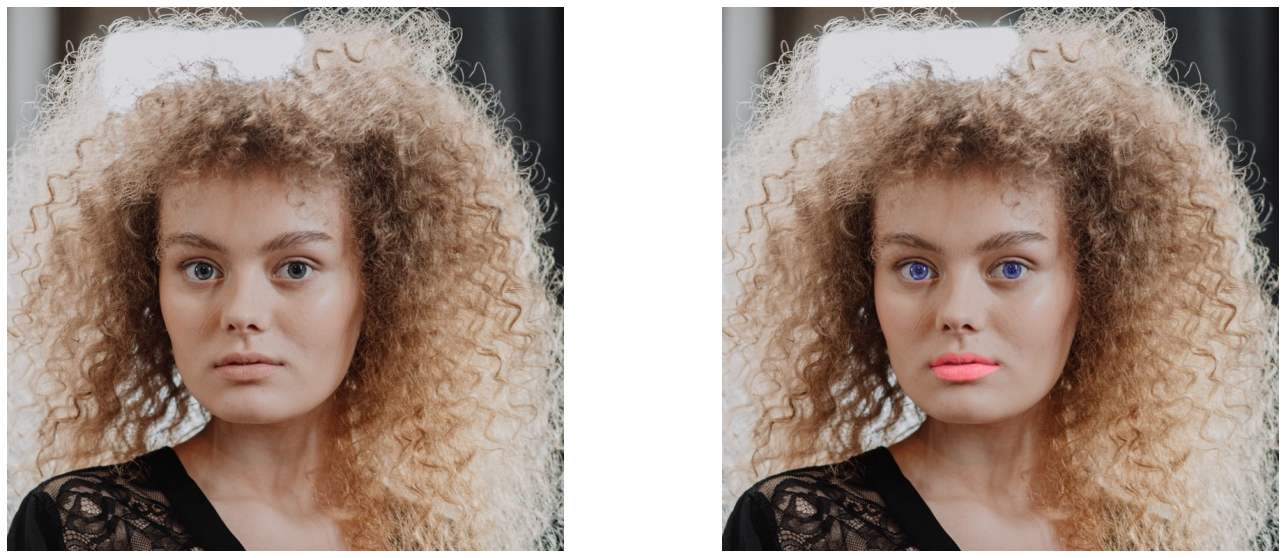

In [164]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,10))
axes[0].imshow(im_rgb)
axes[0].axis("off")
axes[1].imshow(im_out)
axes[1].axis("off")
plt.subplots_adjust(wspace=.05, hspace=.05)

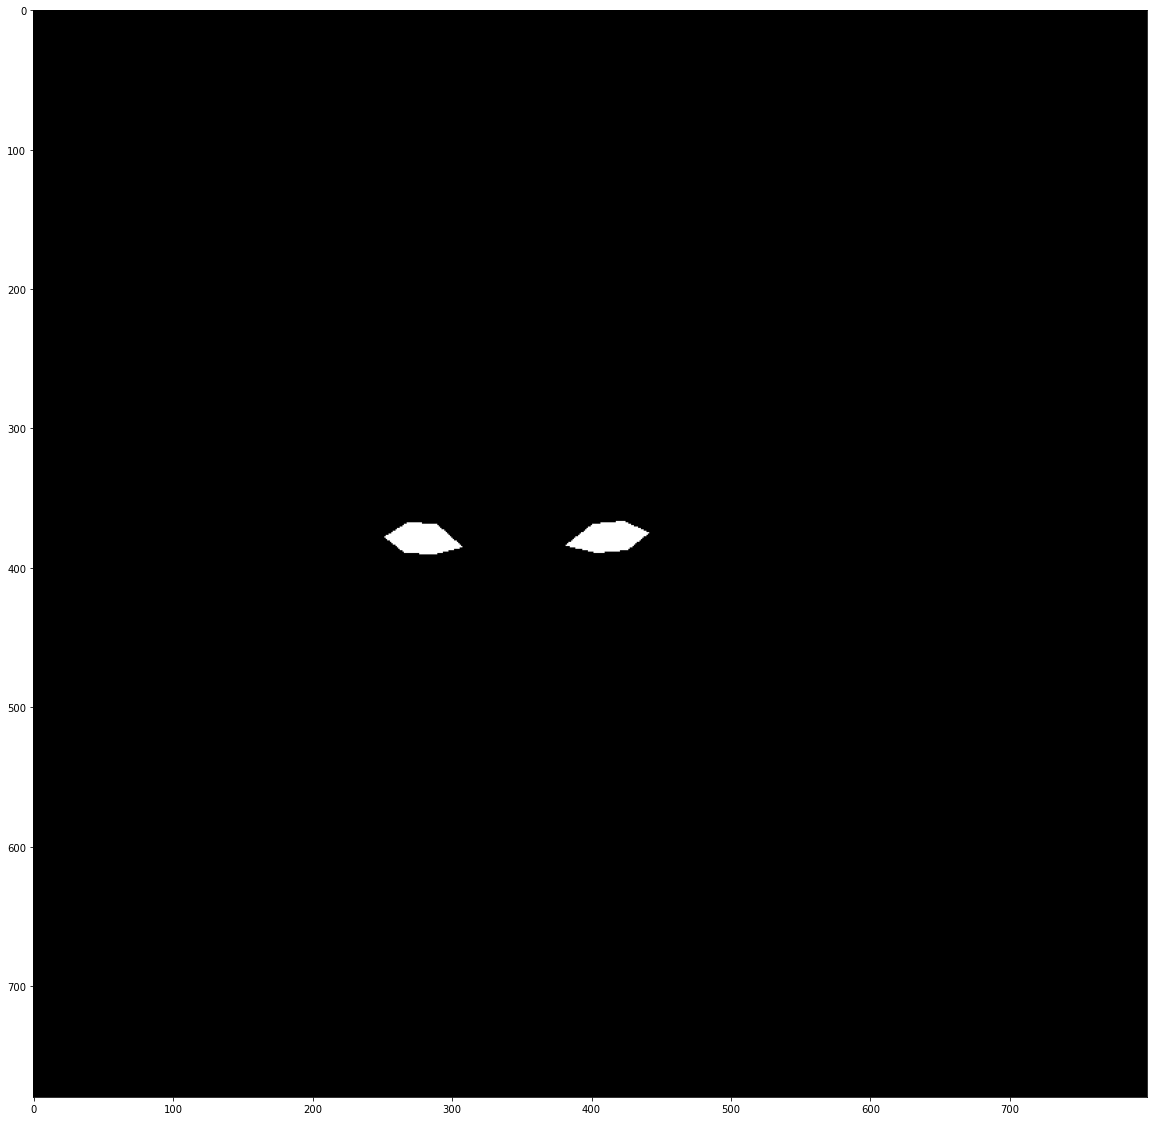

In [83]:
plt.figure(figsize = (20,20))
plt.imshow(eyes_mask)

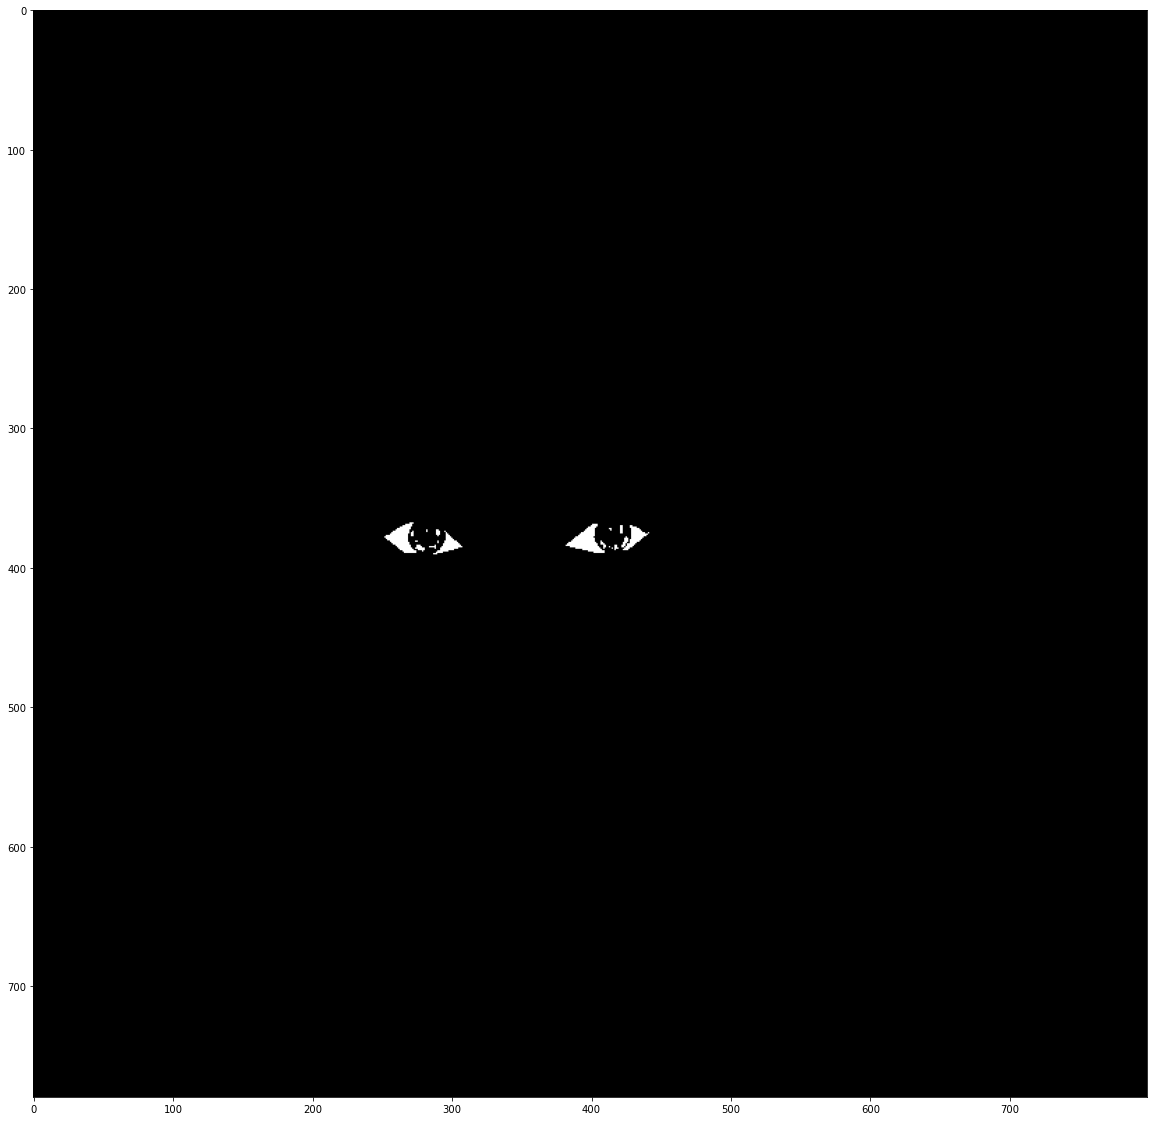

In [111]:
plt.figure(figsize = (20,20))
plt.imshow(thresh_img2)

In [112]:
eyes_mask2 = cv2.bitwise_xor(eyes_mask, thresh_img2)

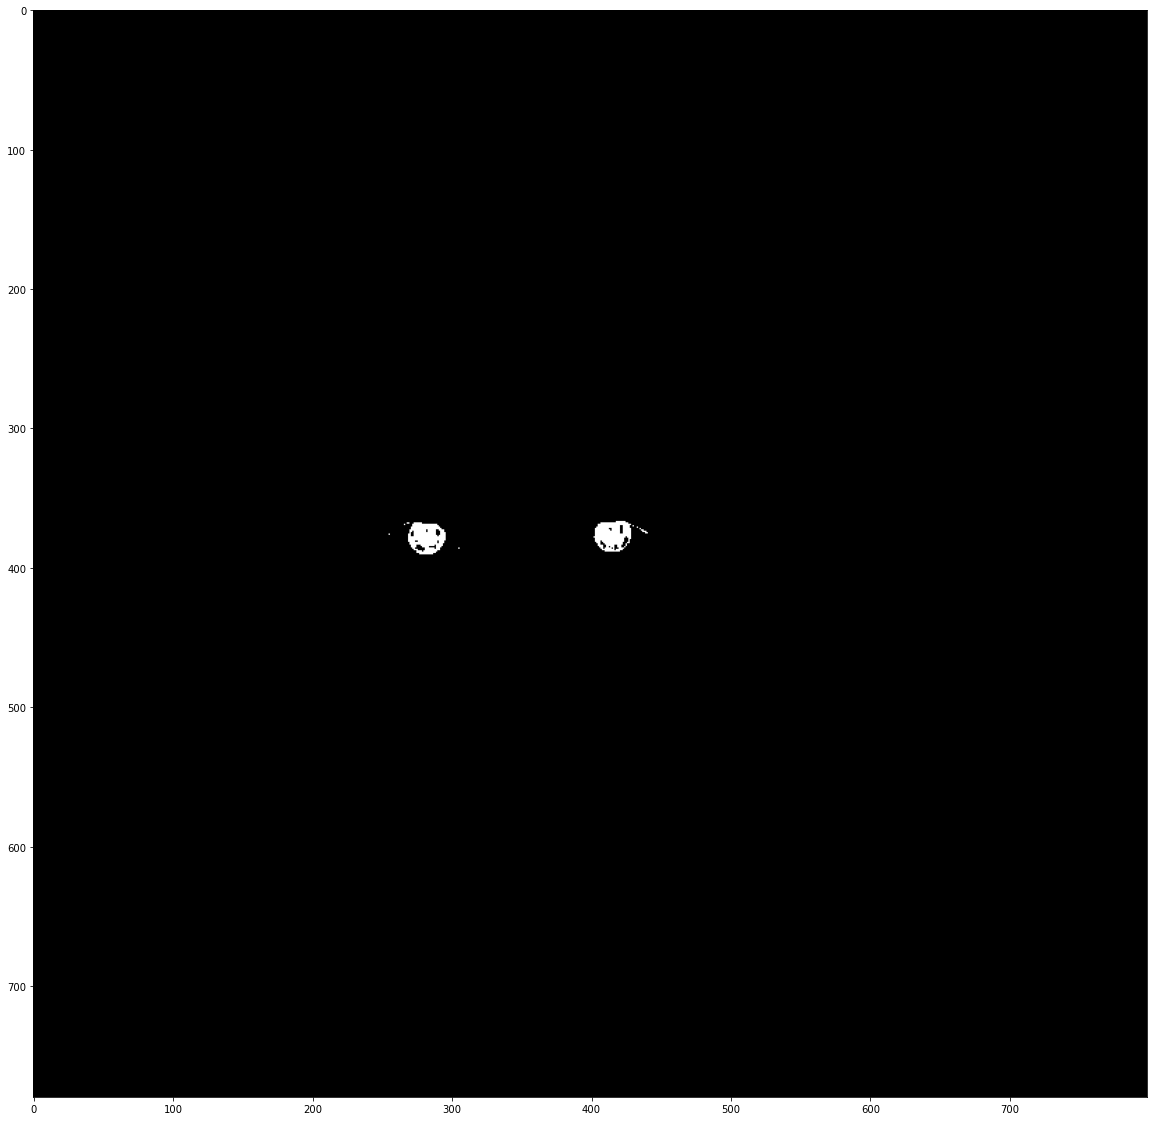

In [113]:
plt.figure(figsize = (20,20))
plt.imshow(eyes_mask2)

In [140]:
# kernel = np.ones((5,5),np.uint8)
kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(5,5))
closing = cv2.morphologyEx(eyes_mask2, cv2.MORPH_CLOSE, kernel)
closing_opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

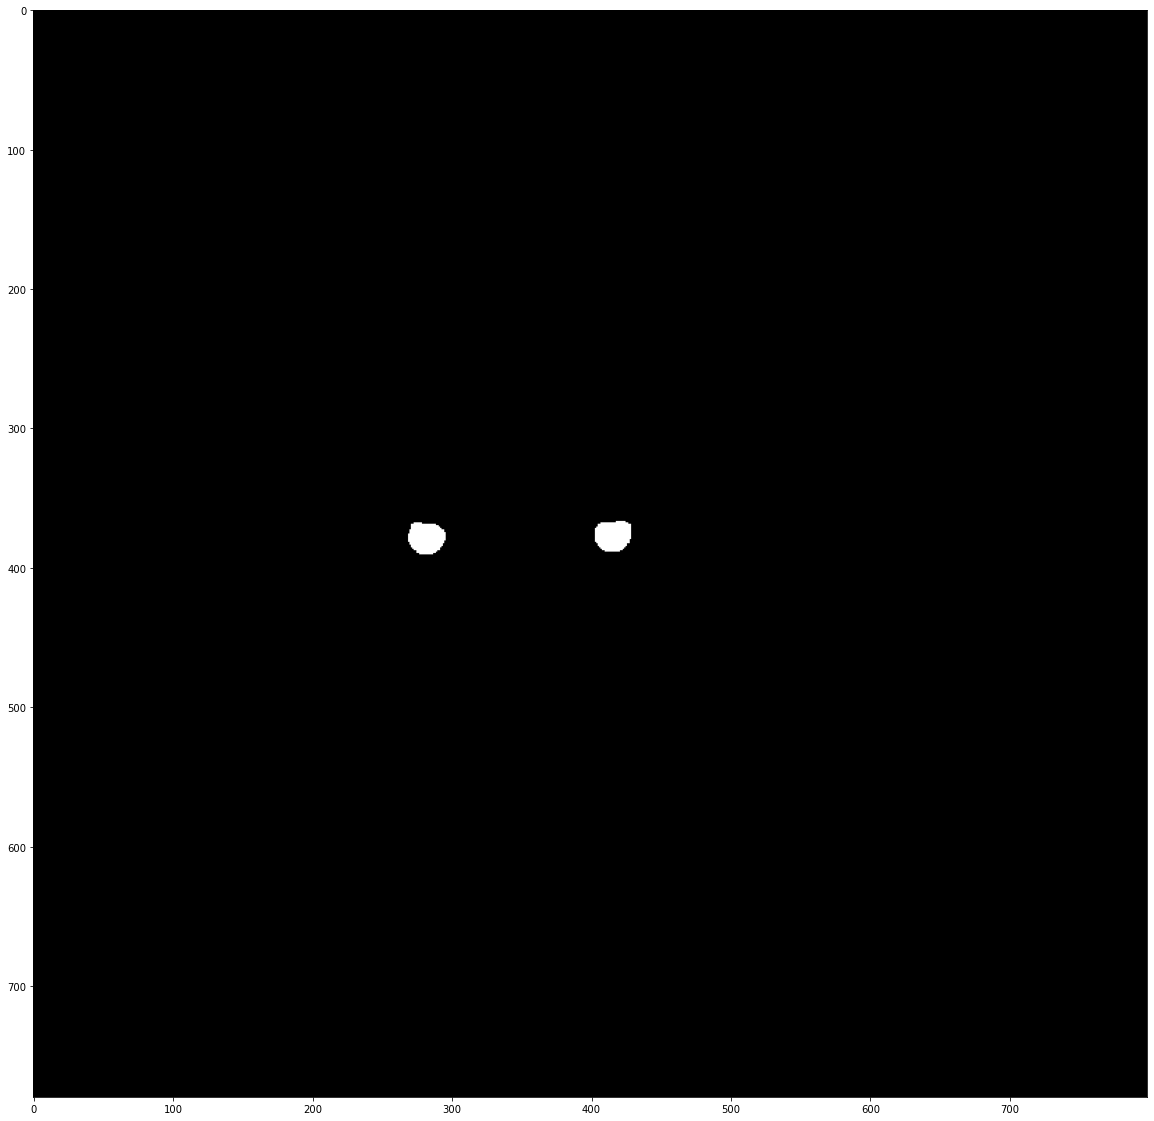

In [141]:
plt.figure(figsize = (20,20))
plt.imshow(closing_opening)

In [146]:
EYES_COLOR = (50, 150, 50)

color_eyes = np.zeros_like(im_rgb)
color_eyes[:] = EYES_COLOR[0], EYES_COLOR[1], EYES_COLOR[2]
color_eyes = cv2.bitwise_and(closing_opening, color_eyes)
color_eyes = cv2.GaussianBlur(color_eyes, (5,5), 10)
output_img = cv2.addWeighted(im_rgb, 1, color_eyes, 0.4,0)

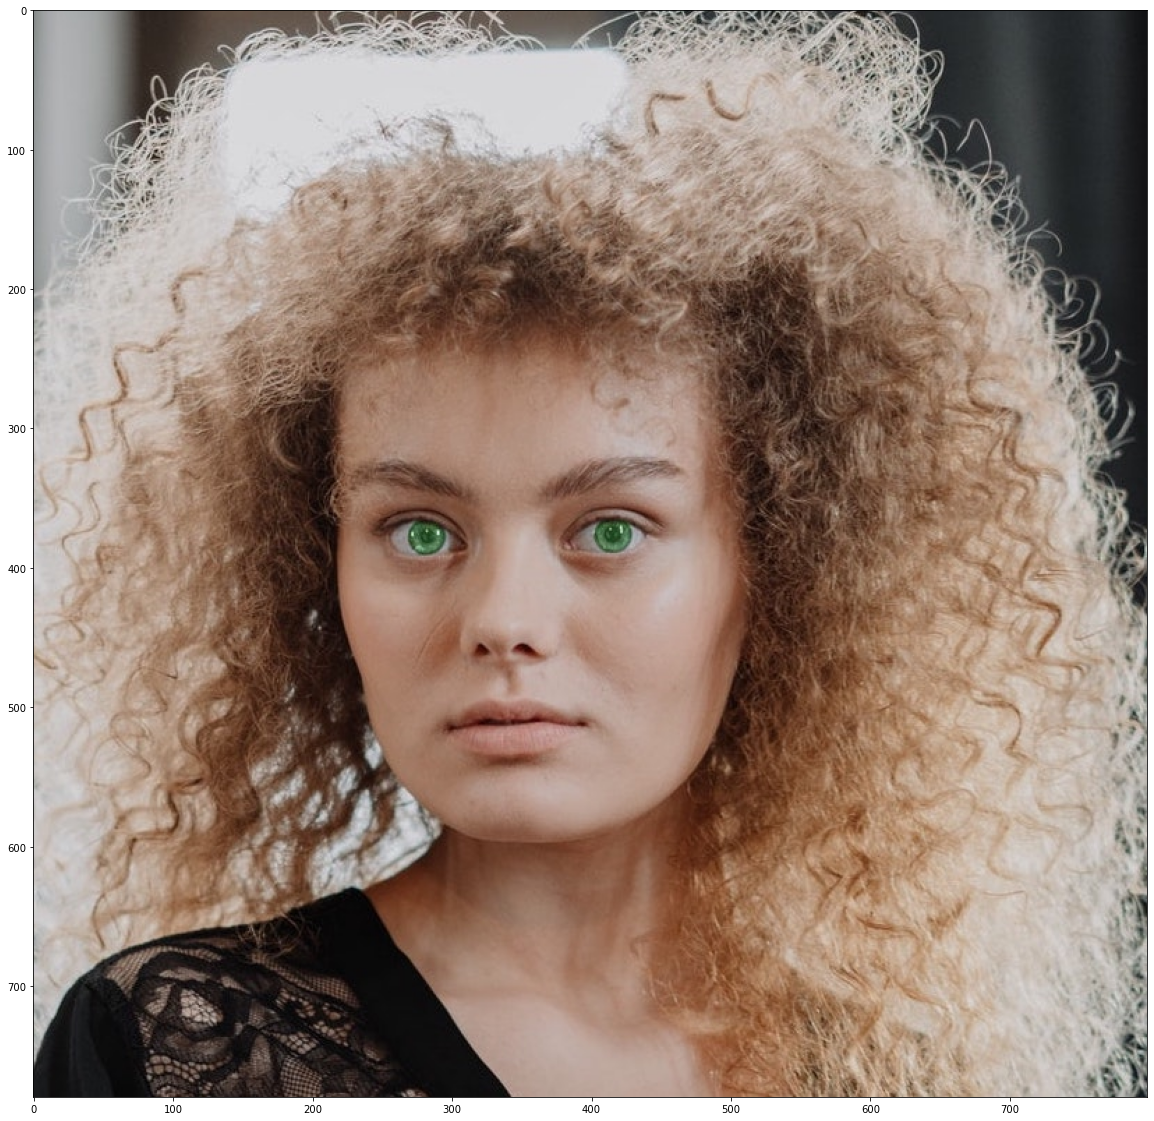

In [147]:
plt.figure(figsize = (20,20))
plt.imshow(output_img)